In [1]:
# Cell 1: Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import librosa


2025-05-23 22:45:27.508901: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-23 22:45:27.520038: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748015127.534121   15933 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748015127.538945   15933 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748015127.549464   15933 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Cell 2: Load và chuẩn bị dữ liệu
# Load metadata
metadata_df = pd.read_csv('../data/features/mel/metadata.csv')

# Create label encoder
le = LabelEncoder()
metadata_df['label'] = le.fit_transform(metadata_df['audio_path'].apply(lambda x: os.path.dirname(x)))

# Load features
X = []
y = []
for idx, row in metadata_df.iterrows():
    feature_path = os.path.join('../data/features/mel', row['feature_path'])
    features = np.load(feature_path)
    X.append(features)
    y.append(row['label'])

X = np.array(X)
y = np.array(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Number of classes: {len(le.classes_)}")
print(f"Classes: {le.classes_}")

Training set shape: (1053, 128, 32)
Testing set shape: (264, 128, 32)
Number of classes: 12
Classes: ['bat_den' 'bat_dieu_hoa' 'bat_quat' 'bat_tv' 'do_am' 'dong_rem' 'mo_rem'
 'nhiet_do' 'tat_den' 'tat_dieu_hoa' 'tat_quat' 'tat_tv']


In [3]:
# # Cell 3: Data Augmentation
def augment_mel(mel_spec):
    augmented = mel_spec.copy()
    
    # Random time stretching
    rate = np.random.uniform(0.8, 1.2)
    augmented = librosa.effects.time_stretch(augmented, rate=rate)
    
    # Resize to original shape if needed
    if augmented.shape != mel_spec.shape:
        augmented = librosa.util.fix_length(augmented, size=mel_spec.shape[1], axis=1)
    
    # Random frequency masking
    if np.random.random() < 0.5:
        freq_mask = np.random.randint(0, mel_spec.shape[0], size=2)
        augmented[freq_mask[0]:freq_mask[1], :] = 0
    
    # Random time masking
    if np.random.random() < 0.5:
        time_mask = np.random.randint(0, mel_spec.shape[1], size=2)
        augmented[:, time_mask[0]:time_mask[1]] = 0
    
    # Add noise
    noise = np.random.normal(0, 0.01, mel_spec.shape)
    augmented = augmented + noise
    
    # Random pitch shifting
    if np.random.random() < 0.5:
        augmented = np.roll(augmented, np.random.randint(-5, 5), axis=0)
    
    return augmented


# Augment training data
X_train_aug = []
y_train_aug = []

for i in range(len(X_train)):
    # Original sample
    X_train_aug.append(X_train[i])
    y_train_aug.append(y_train[i])
    
    # Augmented samples
    for _ in range(5):
        X_train_aug.append(augment_mel(X_train[i]))
        y_train_aug.append(y_train[i])

X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)

/home/anhcbt/extend/DATN_Step11/.env/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=32
  warnings.warn(
/home/anhcbt/extend/DATN_Step11/.env/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=32
  warnings.warn(
/home/anhcbt/extend/DATN_Step11/.env/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=32
  warnings.warn(


In [4]:
# # Cell 4: Model Architecture
def create_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Reshape data
X_train_reshaped = X_train_aug.reshape(X_train_aug.shape[0], X_train_aug.shape[1], X_train_aug.shape[2], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Create model
model = create_model(
    input_shape=(X_train_aug.shape[1], X_train_aug.shape[2], 1),
    num_classes=len(le.classes_)
)

2025-05-23 22:47:21.831126: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
# Cell 5: Training Setup
# Create callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        # patience=15,
        patience=10,
        restore_best_weights=True,
        min_delta=0.001
    ),
    ModelCheckpoint(
        '../data/models/mel_best_model.keras',
        monitor='val_accuracy',
        save_best_only=True
    )
]


# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Giảm learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)  # Giảm learning rate

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [6]:
# Cell 6: Training
history = model.fit(
    X_train_reshaped, y_train_aug,
    epochs=20,
    batch_size=8,
    validation_split=0.2,
    callbacks=callbacks
)

Epoch 1/20
632/632 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.1576 - loss: 2.5760 - val_accuracy: 0.3877 - val_loss: 1.7772
Epoch 2/20
632/632 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3868 - loss: 1.7270 - val_accuracy: 0.5712 - val_loss: 1.2906
Epoch 3/20
632/632 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5715 - loss: 1.1796 - val_accuracy: 0.6005 - val_loss: 1.2572
Epoch 4/20
632/632 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6752 - loss: 0.8989 - val_accuracy: 0.6408 - val_loss: 1.1251
Epoch 5/20
632/632 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7384 - loss: 0.7302 - val_accuracy: 0.6962 - val_loss: 1.0269
Epoch 6/20
632/632 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7905 - loss: 0.5868 - val_accuracy: 0.7097 - val_loss: 1.2251
Epoch 7/20
632/632 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8019 - loss: 0.5314 - val_accuracy: 0.7255 - val_loss: 0.9635
Epoch 8/20
632/632 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8313 - loss: 0.4515 - val_accuracy: 0.

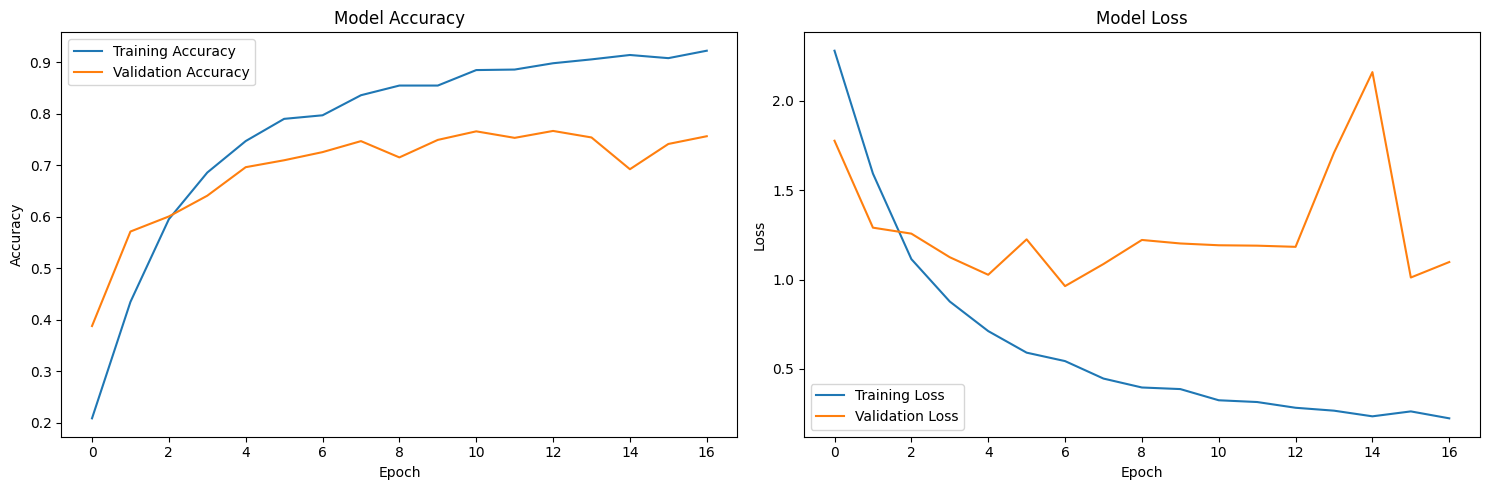

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8292 - loss: 0.5822  

Test accuracy: 0.8409
Test loss: 0.5289
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


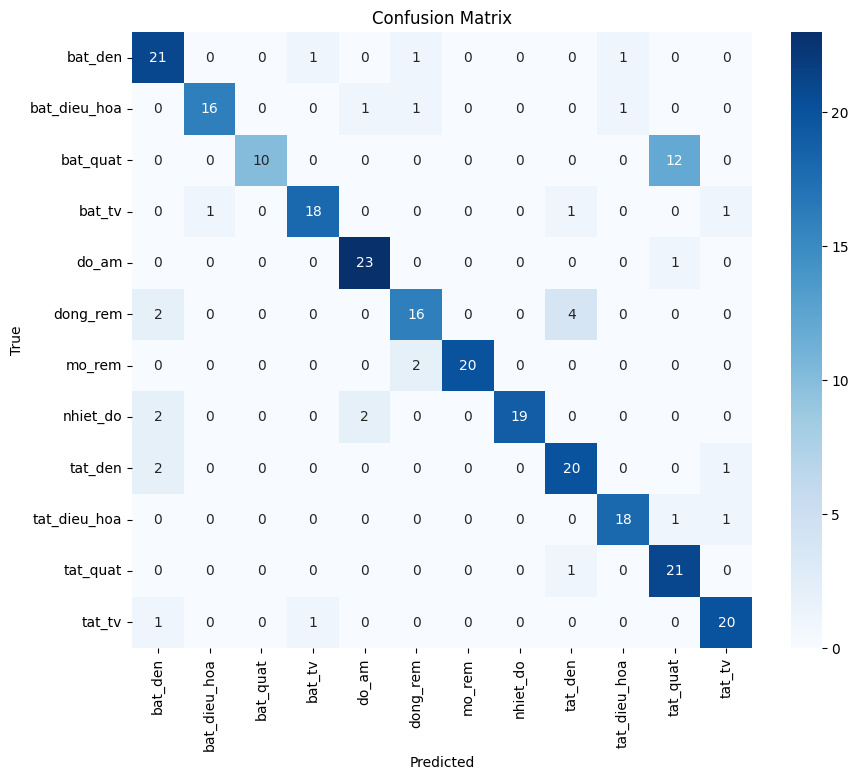


Classification Report:
              precision    recall  f1-score   support

     bat_den       0.75      0.88      0.81        24
bat_dieu_hoa       0.94      0.84      0.89        19
    bat_quat       1.00      0.45      0.62        22
      bat_tv       0.90      0.86      0.88        21
       do_am       0.88      0.96      0.92        24
    dong_rem       0.80      0.73      0.76        22
      mo_rem       1.00      0.91      0.95        22
    nhiet_do       1.00      0.83      0.90        23
     tat_den       0.77      0.87      0.82        23
tat_dieu_hoa       0.90      0.90      0.90        20
    tat_quat       0.60      0.95      0.74        22
      tat_tv       0.87      0.91      0.89        22

    accuracy                           0.84       264
   macro avg       0.87      0.84      0.84       264
weighted avg       0.87      0.84      0.84       264



In [7]:
# Cell 7: Evaluation và Visualization
# Plot training history
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"\nTest accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Get predictions
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

In [8]:
# Cell 8: Save model và encoder
# Save model
model.save('../data/models/mel_final_model.keras')

# Save label encoder
import pickle
with open('../data/models/mel_label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("Model and label encoder saved successfully!")

Model and label encoder saved successfully!
